# Reading general data of the problems


In [1]:
# coding=utf-8
from __future__ import division
import json
import os
import sys

from MyUtils import clean_folder, read_files
from Word2Dim import Word2Dim

dataset_path = '.' + os.sep + 'pan19-cross-domain-authorship-attribution-training-dataset-2019-01-23'
outpath = '.' + os.sep + 'dev_out'

clean_folder(outpath)

infocollection = dataset_path + os.sep + 'collection-info.json'
problems = []
language = []
with open(infocollection, 'r') as f:
    for attrib in json.load(f):
        problems.append(attrib['problem-name'])
        language.append(attrib['language'])
print('Reading general data of the problems, done!')


Reading general data of the problems, done!


# Reading problem 1

In [2]:

problem = problems[0]
index = 0

# used for n_gram extraction and word indexing, a threshold which prevent words appearing lower than this value to be counted in calculations
tf = 5


infoproblem = dataset_path + os.sep + problem + os.sep + 'problem-info.json'
candidates = []
with open(infoproblem, 'r') as f:
    fj = json.load(f)
    unk_folder = fj['unknown-folder']
    for attrib in fj['candidate-authors']:
        candidates.append(attrib['author-name'])

candidates.sort()
# Building training set
train_docs = []
for candidate in candidates:
    train_docs.extend(read_files(dataset_path + os.sep + problem, candidate))
train_texts = [text for i, (text, label) in enumerate(train_docs)]
train_labels = [label for i, (text, label) in enumerate(train_docs)]
index_2_label_dict = {i: l for i, l in enumerate(set(train_labels))}
label_2_index_dict = {l: i for i, l in enumerate(set(train_labels))}
train_labels = [label_2_index_dict[v] for v in train_labels]
w2d = Word2Dim()
train_tokenized_with_pos, train_tokenized_indexed = w2d.fit_transform_texts(train_texts, train_labels,
                                                                            language[index], tf= tf)

maxlen = len(max(train_tokenized_indexed, key=len))  # We will cut the texts after # words
embedding_dim = w2d.word_embedding.shape[1]

# preparing test set
ground_truth_file = dataset_path + os.sep + problem + os.sep + 'ground-truth.json'
gt = {}
with open(ground_truth_file, 'r') as f:
    for attrib in json.load(f)['ground_truth']:
        gt[attrib['unknown-text']] = attrib['true-author']

test_docs = read_files(dataset_path + os.sep + problem, unk_folder, gt)
test_texts = [text for i, (text, label) in enumerate(test_docs)]
test_labels = [label for i, (text, label) in enumerate(test_docs)]

# Filter validation to known authors
test_texts = [text for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]
test_labels = [label for i, (text, label) in enumerate(test_docs) if label in label_2_index_dict.keys()]

test_labels = [label_2_index_dict[v] for v in test_labels]

test_tokenized_with_pos, test_tokenized_indexed = w2d.transform(test_texts)
print("Reading problem 1, done!")

doc count to process:  63
process_doc, done!
doc count to process:  468
Reading problem 1, done!


# Data Extraction for Neural Net



In [16]:
from MyUtils import extract_n_grams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

n = 3
vocabulary = extract_n_grams(train_docs, n, tf)
vectorizer = CountVectorizer(analyzer='char', ngram_range=(n, n), lowercase=False, vocabulary=vocabulary)
n_gram_train_data = vectorizer.fit_transform(train_texts)

n_gram_train_data = n_gram_train_data.astype(float)

for i, v in enumerate(train_texts):
    n_gram_train_data[i] = n_gram_train_data[i] / len(train_texts[i])
n_gram_test_data = vectorizer.transform(test_texts)
n_gram_test_data = n_gram_test_data.astype(float)
for i, v in enumerate(test_texts):
    n_gram_test_data[i] = n_gram_test_data[i] / len(test_texts[i])
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_ngrams = max_abs_scaler.fit_transform(n_gram_train_data)
scaled_test_data_ngrams = max_abs_scaler.transform(n_gram_test_data)
max_abs_scaler = preprocessing.MaxAbsScaler()
scaled_train_data_words = max_abs_scaler.fit_transform(w2d.get_texts_vectorized_and_normalized(train_tokenized_indexed)[:, 1:])
scaled_test_data_words = max_abs_scaler.transform(w2d.get_texts_vectorized_and_normalized(test_tokenized_indexed)[:, 1:])
print("Done!")

Done!


In [20]:
print(scaled_train_data_words.shape)
print(scaled_test_data_words.shape)
print(len(w2d.word_index))

(63, 1302)
(468, 1302)
1302


In [25]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input, callbacks
from keras.models import Sequential, Model
from keras import optimizers, regularizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=40,
    ),
    callbacks.ModelCheckpoint(
        filepath='my_model.h5',
        monitor='val_loss',
        save_best_only=True,
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        verbose=1, 
        patience=20,
    )
]

train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=len(set(train_labels)), random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
# print(X_train.shape)

print(scaled_train_data_ngrams.shape)
print()

(63, 4152)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n_grams (InputLayer)            (None, 4152)         0                                            
__________________________________________________________________________________________________
words (InputLayer)              (None, 1302)         0                                            
__________________________________________________________________________________________________
sequential_21 (Sequential)      (None, 64)           139168      n_grams[0][0]                    
__________________________________________________________________________________________________
sequential_22 (Sequential)      (None, 64)           47968       words[0][0]                      
__________________________________________________________________________________________________
concatenat

Epoch 46/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.7244 - acc: 0.9683 - val_loss: 4.0127 - val_acc: 0.8953
Epoch 47/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.6547 - acc: 0.9524 - val_loss: 3.9969 - val_acc: 0.8761
Epoch 48/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.6078 - acc: 0.9683 - val_loss: 4.0246 - val_acc: 0.8632
Epoch 49/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.6077 - acc: 0.9524 - val_loss: 3.9242 - val_acc: 0.8761
Epoch 50/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.5902 - acc: 0.9365 - val_loss: 3.8390 - val_acc: 0.8974
Epoch 51/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.6547 - acc: 0.9206 - val_loss: 4.0794 - val_acc: 0.8120
Epoch 52/2000
63/63 [==============================] - 1s 16ms/step - loss: 3.5365 - acc: 0.9524 - val_loss: 3.8680 - val_acc: 0.8718
Epoch 53/2000
63/63 [==============================] - 1s 16ms

63/63 [==============================] - 1s 16ms/step - loss: 2.2681 - acc: 0.9683 - val_loss: 2.5671 - val_acc: 0.9038
Epoch 108/2000
63/63 [==============================] - 1s 16ms/step - loss: 2.3109 - acc: 0.9841 - val_loss: 2.6314 - val_acc: 0.8803
Epoch 109/2000
63/63 [==============================] - 1s 16ms/step - loss: 2.2191 - acc: 0.9841 - val_loss: 2.5422 - val_acc: 0.8974
Epoch 110/2000
63/63 [==============================] - 1s 16ms/step - loss: 2.2150 - acc: 1.0000 - val_loss: 2.6867 - val_acc: 0.8376
Epoch 111/2000
63/63 [==============================] - 1s 16ms/step - loss: 2.1733 - acc: 1.0000 - val_loss: 2.5018 - val_acc: 0.9081
Epoch 112/2000
63/63 [==============================] - 1s 16ms/step - loss: 2.2068 - acc: 0.9683 - val_loss: 2.5570 - val_acc: 0.8654
Epoch 113/2000
63/63 [==============================] - 1s 16ms/step - loss: 2.2215 - acc: 0.9841 - val_loss: 2.4321 - val_acc: 0.9231
Epoch 114/2000
63/63 [==============================] - 1s 16ms/step -

Epoch 168/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.6382 - acc: 1.0000 - val_loss: 1.9870 - val_acc: 0.8739
Epoch 169/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.5691 - acc: 1.0000 - val_loss: 1.9400 - val_acc: 0.8739
Epoch 170/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.5771 - acc: 1.0000 - val_loss: 1.9155 - val_acc: 0.8868
Epoch 171/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.5690 - acc: 1.0000 - val_loss: 1.9318 - val_acc: 0.9038
Epoch 172/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.5766 - acc: 1.0000 - val_loss: 1.9580 - val_acc: 0.8910
Epoch 173/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.5854 - acc: 0.9524 - val_loss: 1.9486 - val_acc: 0.9038
Epoch 174/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.5624 - acc: 0.9841 - val_loss: 2.0346 - val_acc: 0.8483
Epoch 175/2000
63/63 [==============================] -

Epoch 229/2000
63/63 [==============================] - 1s 17ms/step - loss: 1.2777 - acc: 0.9841 - val_loss: 1.6585 - val_acc: 0.8611
Epoch 230/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.3065 - acc: 0.9683 - val_loss: 1.6719 - val_acc: 0.8932
Epoch 231/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.2744 - acc: 1.0000 - val_loss: 1.5731 - val_acc: 0.9038
Epoch 232/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.2586 - acc: 0.9683 - val_loss: 1.9201 - val_acc: 0.7479
Epoch 233/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.2708 - acc: 0.9683 - val_loss: 1.6365 - val_acc: 0.8846
Epoch 234/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.2059 - acc: 1.0000 - val_loss: 1.5557 - val_acc: 0.8974
Epoch 235/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.2032 - acc: 1.0000 - val_loss: 1.6214 - val_acc: 0.8868
Epoch 236/2000
63/63 [==============================] -

Epoch 290/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.0531 - acc: 1.0000 - val_loss: 1.3802 - val_acc: 0.8953
Epoch 291/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.0992 - acc: 0.9683 - val_loss: 1.3511 - val_acc: 0.9060
Epoch 292/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.0436 - acc: 0.9841 - val_loss: 1.3547 - val_acc: 0.9038
Epoch 293/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.0252 - acc: 0.9841 - val_loss: 1.3841 - val_acc: 0.8974
Epoch 294/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.0039 - acc: 1.0000 - val_loss: 1.3597 - val_acc: 0.8868
Epoch 295/2000
63/63 [==============================] - 1s 17ms/step - loss: 1.0191 - acc: 0.9841 - val_loss: 1.5244 - val_acc: 0.8440
Epoch 296/2000
63/63 [==============================] - 1s 16ms/step - loss: 1.0359 - acc: 0.9841 - val_loss: 1.4357 - val_acc: 0.8654
Epoch 297/2000
63/63 [==============================] -

Epoch 351/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.9178 - acc: 0.9841 - val_loss: 1.2611 - val_acc: 0.8932
Epoch 352/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.9584 - acc: 0.9841 - val_loss: 1.6346 - val_acc: 0.7479
Epoch 353/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.9235 - acc: 1.0000 - val_loss: 1.3215 - val_acc: 0.8718
Epoch 354/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.9800 - acc: 0.9841 - val_loss: 1.3054 - val_acc: 0.8825
Epoch 355/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.9226 - acc: 0.9841 - val_loss: 1.4594 - val_acc: 0.7970
Epoch 356/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.8880 - acc: 1.0000 - val_loss: 1.2904 - val_acc: 0.8739
Epoch 357/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.9328 - acc: 1.0000 - val_loss: 1.4370 - val_acc: 0.8291
Epoch 358/2000
63/63 [==============================] -

63/63 [==============================] - 1s 16ms/step - loss: 0.8340 - acc: 1.0000 - val_loss: 1.1980 - val_acc: 0.8846
Epoch 412/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7874 - acc: 1.0000 - val_loss: 1.2198 - val_acc: 0.8932
Epoch 413/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.8044 - acc: 1.0000 - val_loss: 1.2198 - val_acc: 0.8782
Epoch 414/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.8052 - acc: 0.9841 - val_loss: 1.3007 - val_acc: 0.8376
Epoch 415/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7809 - acc: 1.0000 - val_loss: 1.1762 - val_acc: 0.8910
Epoch 416/2000
63/63 [==============================] - 1s 17ms/step - loss: 0.8352 - acc: 1.0000 - val_loss: 1.2389 - val_acc: 0.8547
Epoch 417/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7835 - acc: 1.0000 - val_loss: 1.2161 - val_acc: 0.8632
Epoch 418/2000
63/63 [==============================] - 1s 16ms/step -

63/63 [==============================] - 1s 16ms/step - loss: 0.7304 - acc: 1.0000 - val_loss: 1.1633 - val_acc: 0.8761
Epoch 471/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7385 - acc: 1.0000 - val_loss: 1.1657 - val_acc: 0.8718
Epoch 472/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7237 - acc: 1.0000 - val_loss: 1.1577 - val_acc: 0.8697
Epoch 473/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7484 - acc: 0.9841 - val_loss: 1.1432 - val_acc: 0.8675
Epoch 474/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7536 - acc: 1.0000 - val_loss: 1.1513 - val_acc: 0.8675
Epoch 475/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7563 - acc: 0.9841 - val_loss: 1.1581 - val_acc: 0.8739
Epoch 476/2000
63/63 [==============================] - 1s 16ms/step - loss: 0.7773 - acc: 0.9683 - val_loss: 1.1487 - val_acc: 0.8761
Epoch 477/2000
63/63 [==============================] - 1s 16ms/step -

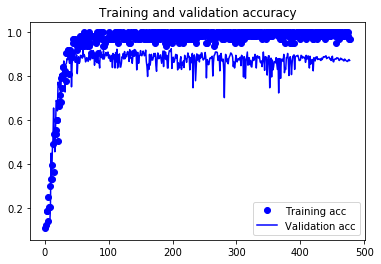

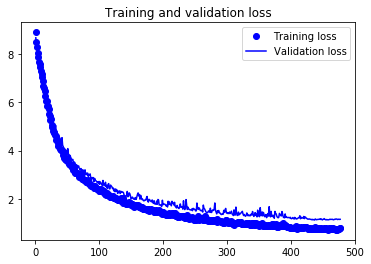

0.9252136752136753


In [44]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

word_input_tensor = Input(shape=(scaled_train_data_words.shape[1],) , name='words')
ngram_input_tensor = Input(shape=(scaled_train_data_ngrams.shape[1],) , name='n_grams')

neu0 = Sequential()
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))

neu1 = Sequential()
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))

output_tensor_0 = neu0(ngram_input_tensor)
output_tensor_1 = neu1(word_input_tensor)

concatenated = layers.concatenate([output_tensor_0,
                                   output_tensor_1
                                  ], axis=-1)

concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model([ngram_input_tensor, word_input_tensor], concatenated)
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()
history = model.fit([scaled_train_data_ngrams, scaled_train_data_words], y_train,
                    validation_data=([scaled_test_data_ngrams, scaled_test_data_words], y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n_grams (InputLayer)            (None, 4152)         0                                            
__________________________________________________________________________________________________
words (InputLayer)              (None, 1302)         0                                            
__________________________________________________________________________________________________
convnets (InputLayer)           (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_38 (Sequential)      (None, 64)           139168      n_grams[0][0]                    
__________________________________________________________________________________________________
sequential

63/63 [==============================] - 4s 63ms/step - loss: 4.1010 - acc: 0.8889 - val_loss: 4.5966 - val_acc: 0.7628
Epoch 38/2000
63/63 [==============================] - 4s 62ms/step - loss: 3.8367 - acc: 0.9841 - val_loss: 4.4122 - val_acc: 0.8355
Epoch 39/2000
63/63 [==============================] - 4s 63ms/step - loss: 3.8296 - acc: 0.9524 - val_loss: 4.4936 - val_acc: 0.7650
Epoch 40/2000
63/63 [==============================] - 4s 65ms/step - loss: 3.7610 - acc: 0.9365 - val_loss: 4.3377 - val_acc: 0.7970
Epoch 41/2000
63/63 [==============================] - 4s 64ms/step - loss: 3.7552 - acc: 0.9524 - val_loss: 4.4038 - val_acc: 0.7393
Epoch 42/2000
63/63 [==============================] - 4s 64ms/step - loss: 3.6121 - acc: 0.9841 - val_loss: 4.4218 - val_acc: 0.7094
Epoch 43/2000
63/63 [==============================] - 4s 65ms/step - loss: 3.6313 - acc: 0.9524 - val_loss: 4.3216 - val_acc: 0.7607
Epoch 44/2000
63/63 [==============================] - 4s 66ms/step - loss: 

63/63 [==============================] - 4s 64ms/step - loss: 1.9353 - acc: 1.0000 - val_loss: 2.6913 - val_acc: 0.7415
Epoch 99/2000
63/63 [==============================] - 4s 65ms/step - loss: 1.9460 - acc: 1.0000 - val_loss: 2.6519 - val_acc: 0.7585
Epoch 100/2000
63/63 [==============================] - 4s 63ms/step - loss: 1.8897 - acc: 1.0000 - val_loss: 2.7390 - val_acc: 0.7009
Epoch 101/2000
63/63 [==============================] - 4s 65ms/step - loss: 1.8552 - acc: 1.0000 - val_loss: 2.6496 - val_acc: 0.7201
Epoch 102/2000
63/63 [==============================] - 4s 62ms/step - loss: 1.8580 - acc: 1.0000 - val_loss: 2.5533 - val_acc: 0.7799
Epoch 103/2000
63/63 [==============================] - 4s 64ms/step - loss: 1.8327 - acc: 1.0000 - val_loss: 2.7985 - val_acc: 0.6667
Epoch 104/2000
63/63 [==============================] - 4s 66ms/step - loss: 1.8368 - acc: 1.0000 - val_loss: 2.5657 - val_acc: 0.7415
Epoch 105/2000
63/63 [==============================] - 4s 64ms/step - 

Epoch 159/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.8487 - acc: 1.0000 - val_loss: 1.8356 - val_acc: 0.6474
Epoch 160/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.8792 - acc: 0.9841 - val_loss: 1.7990 - val_acc: 0.6560
Epoch 161/2000
63/63 [==============================] - 4s 66ms/step - loss: 0.8370 - acc: 1.0000 - val_loss: 2.0233 - val_acc: 0.5513
Epoch 162/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.8124 - acc: 1.0000 - val_loss: 1.7764 - val_acc: 0.6581
Epoch 163/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.7996 - acc: 1.0000 - val_loss: 1.9746 - val_acc: 0.5705
Epoch 164/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.7932 - acc: 1.0000 - val_loss: 1.8169 - val_acc: 0.6026
Epoch 165/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.7734 - acc: 1.0000 - val_loss: 1.8209 - val_acc: 0.6026
Epoch 166/2000
63/63 [==============================] -

Epoch 220/2000
63/63 [==============================] - 4s 66ms/step - loss: 0.2902 - acc: 1.0000 - val_loss: 1.6326 - val_acc: 0.5342
Epoch 221/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.2806 - acc: 1.0000 - val_loss: 1.5845 - val_acc: 0.5342
Epoch 222/2000
63/63 [==============================] - 4s 65ms/step - loss: 0.2782 - acc: 1.0000 - val_loss: 1.5856 - val_acc: 0.5449
Epoch 223/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.2802 - acc: 1.0000 - val_loss: 1.4892 - val_acc: 0.5855
Epoch 224/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.2733 - acc: 1.0000 - val_loss: 1.4518 - val_acc: 0.5833
Epoch 225/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.2838 - acc: 1.0000 - val_loss: 1.5542 - val_acc: 0.5449
Epoch 226/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.2703 - acc: 1.0000 - val_loss: 1.6476 - val_acc: 0.5043
Epoch 227/2000
63/63 [==============================] -

63/63 [==============================] - 4s 65ms/step - loss: 0.1794 - acc: 1.0000 - val_loss: 1.4187 - val_acc: 0.5598
Epoch 281/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.1761 - acc: 1.0000 - val_loss: 1.4160 - val_acc: 0.5556
Epoch 282/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.1797 - acc: 1.0000 - val_loss: 1.3869 - val_acc: 0.5726
Epoch 283/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.1780 - acc: 1.0000 - val_loss: 1.4172 - val_acc: 0.5534
Epoch 284/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.1801 - acc: 1.0000 - val_loss: 1.4308 - val_acc: 0.5534
Epoch 285/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.1804 - acc: 1.0000 - val_loss: 1.4326 - val_acc: 0.5598
Epoch 286/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.1783 - acc: 1.0000 - val_loss: 1.3562 - val_acc: 0.5983
Epoch 287/2000
63/63 [==============================] - 4s 64ms/step -

63/63 [==============================] - 4s 61ms/step - loss: 0.1497 - acc: 1.0000 - val_loss: 1.3885 - val_acc: 0.5662
Epoch 341/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.1518 - acc: 1.0000 - val_loss: 1.3998 - val_acc: 0.5556
Epoch 342/2000
63/63 [==============================] - 4s 59ms/step - loss: 0.1473 - acc: 1.0000 - val_loss: 1.3878 - val_acc: 0.5598
Epoch 343/2000
63/63 [==============================] - 4s 61ms/step - loss: 0.1497 - acc: 1.0000 - val_loss: 1.4001 - val_acc: 0.5577

Epoch 00343: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.


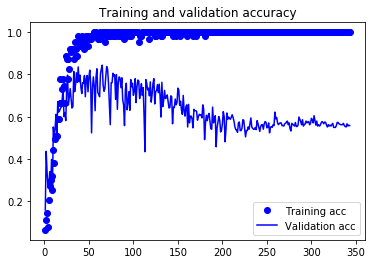

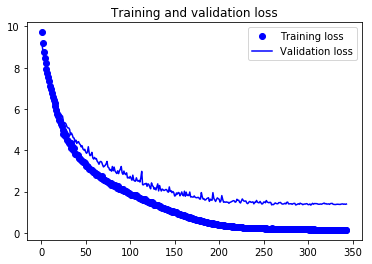

0.844017094017094


In [48]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

word_input_tensor = Input(shape=(scaled_train_data_words.shape[1],) , name='words')
ngram_input_tensor = Input(shape=(scaled_train_data_ngrams.shape[1],) , name='n_grams')

neu0 = Sequential()
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))

neu1 = Sequential()
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))

output_tensor_0 = neu0(ngram_input_tensor)
output_tensor_1 = neu1(word_input_tensor)


conv_input_tensor = Input(shape=(maxlen,) , name='convnets')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())

conv_output_tensor_0 = conv_1d_s3_model(conv_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.2))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())

conv_output_tensor_1 = conv_1d_s1_model(conv_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())

conv_output_tensor_2 = conv_1d_complex_model(conv_input_tensor)



concatenated = layers.concatenate([output_tensor_0,
                                   output_tensor_1,
                                   conv_output_tensor_0,
                                   conv_output_tensor_1,
                                   conv_output_tensor_2,
                                  ], axis=-1)

concatenated = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model([ngram_input_tensor, word_input_tensor, conv_input_tensor], concatenated)
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()
history = model.fit([scaled_train_data_ngrams, scaled_train_data_words, X_train], y_train,
                    validation_data=([scaled_test_data_ngrams, scaled_test_data_words, X_val], y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
n_grams (InputLayer)            (None, 4152)         0                                            
__________________________________________________________________________________________________
words (InputLayer)              (None, 1302)         0                                            
__________________________________________________________________________________________________
convnets (InputLayer)           (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_43 (Sequential)      (None, 32)           68048       n_grams[0][0]                    
__________________________________________________________________________________________________
sequential

63/63 [==============================] - 4s 60ms/step - loss: 2.7657 - acc: 0.8254 - val_loss: 3.3100 - val_acc: 0.7756
Epoch 38/2000
63/63 [==============================] - 4s 60ms/step - loss: 2.6519 - acc: 0.8095 - val_loss: 3.2236 - val_acc: 0.7778
Epoch 39/2000
63/63 [==============================] - 4s 60ms/step - loss: 2.5792 - acc: 0.9206 - val_loss: 3.1807 - val_acc: 0.8034
Epoch 40/2000
63/63 [==============================] - 4s 59ms/step - loss: 2.7127 - acc: 0.8413 - val_loss: 3.0942 - val_acc: 0.7863
Epoch 41/2000
63/63 [==============================] - 4s 65ms/step - loss: 2.6092 - acc: 0.8413 - val_loss: 3.1014 - val_acc: 0.8056
Epoch 42/2000
63/63 [==============================] - 4s 60ms/step - loss: 2.3919 - acc: 0.9206 - val_loss: 3.0442 - val_acc: 0.8205
Epoch 43/2000
63/63 [==============================] - 4s 63ms/step - loss: 2.4015 - acc: 0.9524 - val_loss: 3.0663 - val_acc: 0.7927
Epoch 44/2000
63/63 [==============================] - 4s 65ms/step - loss: 

63/63 [==============================] - 4s 61ms/step - loss: 1.3525 - acc: 0.9841 - val_loss: 1.9998 - val_acc: 0.7650
Epoch 99/2000
63/63 [==============================] - 4s 62ms/step - loss: 1.3710 - acc: 0.9841 - val_loss: 2.0339 - val_acc: 0.7671
Epoch 100/2000
63/63 [==============================] - 4s 63ms/step - loss: 1.3109 - acc: 0.9841 - val_loss: 2.0458 - val_acc: 0.7585
Epoch 101/2000
63/63 [==============================] - 4s 59ms/step - loss: 1.2733 - acc: 1.0000 - val_loss: 1.9678 - val_acc: 0.7842
Epoch 102/2000
63/63 [==============================] - 4s 62ms/step - loss: 1.2666 - acc: 1.0000 - val_loss: 1.9904 - val_acc: 0.7543
Epoch 103/2000
63/63 [==============================] - 4s 61ms/step - loss: 1.2486 - acc: 0.9841 - val_loss: 1.9112 - val_acc: 0.7650
Epoch 104/2000
63/63 [==============================] - 4s 63ms/step - loss: 1.2767 - acc: 0.9683 - val_loss: 1.9952 - val_acc: 0.7393
Epoch 105/2000
63/63 [==============================] - 4s 62ms/step - 

Epoch 159/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.7403 - acc: 1.0000 - val_loss: 1.7537 - val_acc: 0.6132
Epoch 160/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.7672 - acc: 1.0000 - val_loss: 1.7650 - val_acc: 0.5983
Epoch 161/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.7516 - acc: 1.0000 - val_loss: 1.6932 - val_acc: 0.6453
Epoch 162/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.7439 - acc: 1.0000 - val_loss: 1.8200 - val_acc: 0.5833
Epoch 163/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.7500 - acc: 1.0000 - val_loss: 1.8928 - val_acc: 0.5577
Epoch 164/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.7068 - acc: 1.0000 - val_loss: 1.8254 - val_acc: 0.5833
Epoch 165/2000
63/63 [==============================] - 4s 64ms/step - loss: 0.7197 - acc: 1.0000 - val_loss: 1.8302 - val_acc: 0.5919
Epoch 166/2000
63/63 [==============================] -

Epoch 220/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.3381 - acc: 1.0000 - val_loss: 1.4476 - val_acc: 0.5919
Epoch 221/2000
63/63 [==============================] - 4s 63ms/step - loss: 0.3365 - acc: 1.0000 - val_loss: 1.4458 - val_acc: 0.5897
Epoch 222/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.3320 - acc: 1.0000 - val_loss: 1.5235 - val_acc: 0.5577
Epoch 223/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.3549 - acc: 1.0000 - val_loss: 1.3354 - val_acc: 0.6474
Epoch 224/2000
63/63 [==============================] - 4s 62ms/step - loss: 0.3179 - acc: 1.0000 - val_loss: 1.4147 - val_acc: 0.6004
Epoch 225/2000
63/63 [==============================] - 4s 58ms/step - loss: 0.3155 - acc: 1.0000 - val_loss: 1.4756 - val_acc: 0.5748
Epoch 226/2000
63/63 [==============================] - 4s 60ms/step - loss: 0.3171 - acc: 1.0000 - val_loss: 1.5496 - val_acc: 0.5513
Epoch 227/2000
63/63 [==============================] -

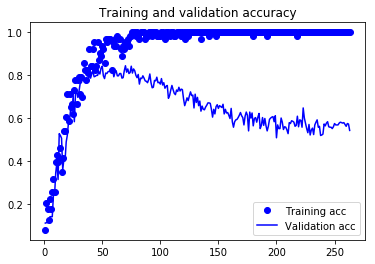

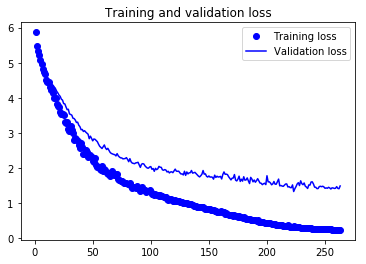

0.844017094017094


In [49]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

word_input_tensor = Input(shape=(scaled_train_data_words.shape[1],) , name='words')
ngram_input_tensor = Input(shape=(scaled_train_data_ngrams.shape[1],) , name='n_grams')

neu0 = Sequential()
neu0.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_ngrams.shape[1],)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))
neu0.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu0.add(layers.Dropout(0.3))

neu1 = Sequential()
neu1.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
                               input_shape=(scaled_train_data_words.shape[1],)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))
neu1.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
neu1.add(layers.Dropout(0.3))

output_tensor_0 = neu0(ngram_input_tensor)
output_tensor_1 = neu1(word_input_tensor)


conv_input_tensor = Input(shape=(maxlen,) , name='convnets')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())

conv_output_tensor_0 = conv_1d_s3_model(conv_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.2))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())

conv_output_tensor_1 = conv_1d_s1_model(conv_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())

conv_output_tensor_2 = conv_1d_complex_model(conv_input_tensor)



concatenated = layers.concatenate([output_tensor_0,
                                   output_tensor_1,
                                   conv_output_tensor_0,
                                   conv_output_tensor_1,
                                   conv_output_tensor_2,
                                  ], axis=-1)

concatenated = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(concatenated)
concatenated = layers.Dropout(0.3)(concatenated)
concatenated = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model([ngram_input_tensor, word_input_tensor, conv_input_tensor], concatenated)
model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()
history = model.fit([scaled_train_data_ngrams, scaled_train_data_words, X_train], y_train,
                    validation_data=([scaled_test_data_ngrams, scaled_test_data_words, X_val], y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list,
                    verbose= 1
                   )
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
print(max(val_acc))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
words (InputLayer)              (None, 1020)         0                                            
__________________________________________________________________________________________________
sequential_98 (Sequential)      (None, 32)           12202       words[0][0]                      
__________________________________________________________________________________________________
sequential_99 (Sequential)      (None, 32)           12184       words[0][0]                      
__________________________________________________________________________________________________
sequential_100 (Sequential)     (None, 32)           12193       words[0][0]                      
__________________________________________________________________________________________________
concatenat

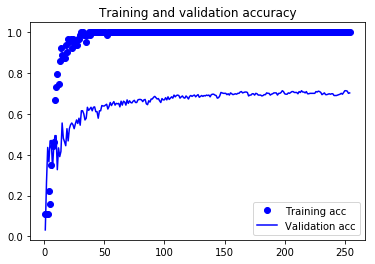

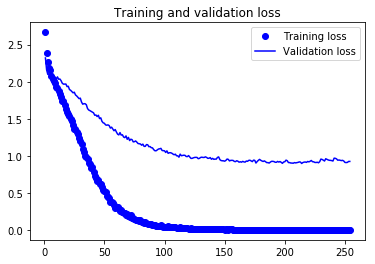

In [53]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)


from keras import layers, Input
from keras.models import Sequential, Model
from keras import optimizers
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split



train_data = pad_sequences(train_tokenized_indexed, maxlen=maxlen)

test_data = pad_sequences(test_tokenized_indexed, maxlen=maxlen)

X_train, X_val, y_train, y_val = train_data, test_data, to_categorical(train_labels), to_categorical(test_labels)
# X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels,
#                                                   test_size=0.28, random_state=2019,
#                                                   stratify=train_labels)

# y_train = to_categorical(y_train)
# y_val = to_categorical(y_val)
word_input_tensor = Input(shape=(maxlen,) , name='words')

conv_1d_s3_model = Sequential()
conv_1d_s3_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s3_model.add(layers.Dropout(0.2))
conv_1d_s3_model.add(layers.SeparableConv1D(32, 3, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s3_model.add(layers.BatchNormalization())
conv_1d_s3_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s3_model.add(layers.BatchNormalization())
# conv_1d_s3_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s3_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s3_model.layers[0].trainable = False
word_output_tensor_0 = conv_1d_s3_model(word_input_tensor)


conv_1d_s1_model = Sequential()
conv_1d_s1_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_s1_model.add(layers.Dropout(0.2))
conv_1d_s1_model.add(layers.SeparableConv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.MaxPooling1D(2))
# conv_1d_s1_model.add(layers.SeparableConv1D(32, 3, activation='relu'))
conv_1d_s1_model.add(layers.GlobalMaxPooling1D())
# conv_1d_s1_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_s1_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_s1_model.layers[0].trainable = False
word_output_tensor_1 = conv_1d_s1_model(word_input_tensor)

conv_1d_complex_model = Sequential()
conv_1d_complex_model.add(layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen))
conv_1d_complex_model.add(layers.Dropout(0.2))
conv_1d_complex_model.add(layers.SeparableConv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001)))
conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
# conv_1d_complex_model.add(layers.MaxPooling1D(2))
# conv_1d_complex_model.add(layers.SeparableConv1D(64, 3, activation='relu'))
# conv_1d_complex_model.add(layers.SeparableConv1D(128, 3, activation='relu'))
conv_1d_complex_model.add(layers.GlobalMaxPooling1D())
# conv_1d_complex_model.add(layers.BatchNormalization())
# conv_1d_s1_model.add(layers.Dense(len(set(train_labels)), activation='softmax'))

# conv_1d_complex_model.layers[0].set_weights([w2d.word_embedding])
# conv_1d_complex_model.layers[0].trainable = False
word_output_tensor_2 = conv_1d_complex_model(word_input_tensor)

# x = layers.Embedding(w2d.word_embedding.shape[0], embedding_dim, input_length=maxlen)(word_input_tensor)
# x = layers.Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001))(x)
# x = layers.Dropout(0.2)(x)
# x = layers.BatchNormalization()(x)
# y = layers.Conv1D(128, 10, activation='relu', padding='same')(x)
# added = layers.add([y, x])
# added = layers.GlobalMaxPooling1D()(added)

concatenated = layers.concatenate([word_output_tensor_0,
                                   word_output_tensor_1,
                                   word_output_tensor_2,
#                                    ,added
                                  ], axis=-1)
# concatenated = layers.Dense(32, activation='relu')(concatenated)
answer = layers.Dense(len(set(train_labels)), activation='softmax')(concatenated)

model = Model(word_input_tensor, answer)
model.summary()

# model.layers[0].set_weights([w2d.word_embedding])
# model.layers[0].trainable = False

model.compile(optimizer=optimizers.Adam(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=2000,
                    batch_size=1,
                    callbacks=callbacks_list,
                    verbose= 2
                   )

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


In [56]:
print(max(val_acc))

0.7136752136752137
